# GW_Forecaster

Codebase for simualting gravitational wave alerts and estimating the precision on the expansion rate of the Universe today under the conditions of various spectroscopic instruments.

---

**Contributors:** Roebrt Morgan, Alyssa Garcia, Mandeep Gill, Tristan Bachmann
<br>
**Primary Notebook Author:** Robert Morgan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Resources from Antonella Palmese

Functions for estimating $\sigma_{H_0}$:

In [2]:
def D0(zerr_v,verr,H0,rho_star): 
    return ((zerr_v**2+verr**2)**0.5)/ (H0*2/rho_star)

def H0_err(zerr_v,verr,H0,rho_star,N,D_star):
    D=D0(zerr_v,verr,H0,rho_star) 
    return H0*2./rho_star/(N**0.5)*((3./5.)**0.5)*(5*D**2/D_star**2 +1.)**0.5

Figure styling:

In [3]:
def plt_style():
    plt.rcParams.update({
    'lines.linewidth':1.0,
    'lines.linestyle':'-',
    'lines.color':'black',
    'font.family':'serif',
    'font.weight':'normal',
    'font.size':17.0,
    'text.color':'black',
    'text.usetex':False,
    'axes.edgecolor':'black',
    'axes.linewidth':1.0,
    'axes.grid':False,
    'axes.titlesize':'large',
    'axes.labelsize':'medium',
    'axes.labelweight':'normal',
    'axes.labelcolor':'black',
    'axes.formatter.limits':[-4,4],
    'xtick.major.size':7,
    'xtick.minor.size':4,
    'xtick.major.pad':8,
    'xtick.minor.pad':8,
    'xtick.labelsize':'medium',
    'xtick.minor.width':1.0,
    'xtick.major.width':1.0,
    'ytick.major.size':7,
    'ytick.minor.size':4,
    'ytick.major.pad':8,
    'ytick.minor.pad':8,
    'ytick.labelsize':'medium',
    'ytick.minor.width':1.0,
    'ytick.major.width':1.0,
    'legend.numpoints':1,
    'legend.fontsize':'medium',
    'legend.shadow':False,
    'legend.frameon':False})

## Objects for simulating GW alerts

In [30]:
class LVC:
    """
    The LVC Class. Store parameters of LVC observing runs
    and provide methods for assinging a distance and a
    localization to each alert.
    """
    def __init__(self, size=1000):
        """
        Store parameters of LVC observing runs.
        
        :param size: int, number of steps in the distributions
        """
        self.size=size
        
        self.O5_MIN_D, self.O5_MAX_D = 0.0, 330.0
        self.O4_LENGTH = 20.0 / 12.0 # 20 months
        self.O4_MIN_D, self.O4_MAX_D = 0.0, 130.0 #Mpc
        self.O3_LENGTH = 1.3 #years
        self.O3_MIN_D, self.O3_MAX_D = 0.0, 85.0 #Mpc
        
        # divide by 2 for visible sky
        # multiply by 0.9 for 90% localization area
        self.O4_alerts = self.calc_num_alerts_per_run(self.O4_MIN_D, self.O4_MAX_D) * self.O4_LENGTH / 2 * 0.9
        self.O5_alerts_per_year = self.calc_num_alerts_per_run(self.O5_MIN_D, self.O5_MAX_D) / 2 * 0.9
        
        self.get_bns_distance_dist()
        self.get_bns_localization_dist()
        return
    

    @staticmethod
    def calc_num_alerts_per_run(min_d, max_d):
        """
        Based on an assumed volumetric rate of BNS mergers, estimate the number
        of BNS mergers per year between the given radii
         - min_d and max_d are in Mpc
        
        :param min_d: float, the inner radius of the annulus
        :param max_d: float, the outer radius of the annulus
        :return: annual_rate: float, the number of BNS mergers per year between the given radii
        """
        def calc_volume(min_d, max_d):
            """
            Calculate the volume of the spherical annulus with given radii

            :param min_d: float, the inner radius of the annulus
            :param max_d: float, the outer radius of the annulus
            :return: volume: float, the  volume of the spherical annulus with given radii
            """
            assert max_d > min_d, "max distance must be greater than min distance"
            return 4.0 / 3.0 * np.pi * (max_d**3 - min_d**3)
        
        # bns-rate = 12,000 per Gpc^3 per yr  (UPPER LIMIT from O1)
        ## from https://iopscience.iop.org/article/10.3847/2041-8205/832/2/L21/pdf

        ANNUAL_VOLUMETRIC_BNS_RATE = 900.0 # Gpc^3 per yr (reduced from upper limit to match O3)
        return calc_volume(min_d * 1.e-3, max_d * 1.e-3) * ANNUAL_VOLUMETRIC_BNS_RATE
    
    def get_bns_distance_dist(self):
        """
        Estimate the distribtuion of distances for the BNS mergers. 
        Assume a uniform rate with redshift.
        """
        # Set distances for both and determine which case to use when simulating alerts
        setattr(self, "O4_distances", np.linspace(self.O4_MIN_D, self.O4_MAX_D, self.size)) #units = Mpc
        setattr(self, "O5_distances", np.linspace(self.O5_MIN_D, self.O5_MAX_D, self.size))
        
        # Assume uniform distances
        weights = np.ones(self.size) / self.size
        setattr(self, "distance_probs", weights)
        return
    
    def get_bns_localization_dist(self):
        """
        Use SNR as a distance proxy to set the localization area.
        """
        # Set distances for both and determine which case to use when simulating alerts
        self.O4_snr_steps = {0: 8.0, 1: 15.0, 2: 21.0, 3: 30.0} 
        self.O5_snr_steps = {0: 3.1, 1: 6.1, 2: 9.3, 3: 12.0}
            
        setattr(self, "O4_areas", lambda snr_quartile: self.O4_snr_steps[snr_quartile])
        setattr(self, "O5_areas", lambda snr_quartile: self.O5_snr_steps[snr_quartile])
        
        # table 2 of https://iopscience.iop.org/article/10.3847/2041-8213/aaacd4/pdf
        # figure 1 of https://arxiv.org/pdf/1904.03187.pdf      
        return

In [5]:
class Alert:
    """
    The Alert Class. Draw from the LVC distributions and calculate 
    alert properties such as brightness, distance uncertainty, etc.
    """
    def __init__(self, lvc, num_of_alerts_so_far):
        """
        Make an alert at the point of initialization.
        
        :param lvc: An instance of the LVC class
        :param num_of_alerts_so_far: int, number of previous alerts
        """
        # Store properties
        self.lvc = lvc
        self.num_of_alerts_so_far = num_of_alerts_so_far
        
        # Draw from LVC distributions
        self.draw_alert_params()
        self.fudge_distange_error()
        
        # Calculate properties of the alert
        self.calc_mag()
        self.calc_dark_siren_sigma_H0()
        self.calc_num_candidates()
        
        return
    
    @staticmethod
    def _draw(values, weights, size=1):
        """
        Draw from a distribution.
        
        :param values: array, the values to choose from
        :param weights: array, the weights for each value (must sum to 1.0)
        :param size: int, the number of draws to make
        :return: selection: single value or array of values
        """
        assert len(values) == len(weights), "values and weights must be the same length"
        selection = np.random.choice(values, p=weights, size=size)
        if size == 1:
            return selection[0]
        else:
            return selection
    
    def draw_alert_params(self):
        """
        Draw distance and localization area from LVC
        """
        if self.num_of_alerts_so_far <= self.lvc.O4_alerts:
            # Draw from O4 distributions
            setattr(self, "distance", self._draw(self.lvc.O4_distances, self.lvc.distance_probs))
            self.get_snr_quartile_idx(self.lvc.O4_MAX_D)
            setattr(self, "area", self.lvc.O4_areas(self.snr_quartile))
        else:
            # Draw from O5 distributions
            setattr(self, "distance", self._draw(self.lvc.O5_distances, self.lvc.distance_probs))
            self.get_snr_quartile_idx(self.lvc.O5_MAX_D)
            setattr(self, "area", self.lvc.O5_areas(self.snr_quartile))
        return
    
    def get_snr_quartile_idx(self, max_d):
        """
        Determine the closest SNR quartile in order to use distance as an SNR proxy.
        """
        snr_quartile = self.distance / max_d * 100
        setattr(self, "snr_quartile", np.argmin(np.abs(np.array([12.5, 37.5, 62.5, 87.5]) - snr_quartile)))
        return
    
    def fudge_distange_error(self):
        """
        Put in a fake uncertainty on distance
        """
        mean_unc = np.sqrt(self.distance)
        fudged_unc = np.random.normal(loc=mean_unc, scale=np.sqrt(mean_unc))
        if fudged_unc < 5.0: fudged_unc = 5.0
        setattr(self, "distance_err", fudged_unc)
        return
        
    def calc_mag(self):
        """
        Assume a luminosity of GW170817 and determine r-mag based on distance
        """
        # Screw the k-correction am I right?
        distance_modulus = 5.0 * np.log10(self.distance * 1000000.0 / 10.0)
        GW170817_ABSOLUTE_R_MAG = -15.8
        setattr(self, "mag", GW170817_ABSOLUTE_R_MAG + distance_modulus)
        return
    
    def calc_dark_siren_sigma_H0(self):
        """
        Estimate a dark siren H0 constraint based photometric redshifts
        """
        setattr(self, "dark_siren_sigma_H0", H0_err(zerr_v=300000*0.01,
                                                  verr=100.0,
                                                  H0=70.0,
                                                  rho_star=8.0,
                                                  N=1.0,
                                                  D_star=self.distance))
        return
    
    def calc_num_candidates(self):
        """
        Estimate the number of spectroscopic targets based on area
        - based on DECam search of GW190814
        -- final candidates (23) in https://gcn.gsfc.nasa.gov/gcn3/25486.gcn3 / final 90% localization area (18.5)
        """
        setattr(self, "num_candidates", self.area * 23.0 / 18.5)
        return

In [6]:
class Detector:
    def __init__(self, limiting_mag, num_targetable_per_night):
        self.limiting_mag = limiting_mag
        self.num_targetable_per_night = num_targetable_per_night
        
    def calculate_curve(self, alerts):
        """
        Calculate the H0 precision vs number of alerts relationship
        """
        sigma_H0_per_alerts = []
        for alert in alerts:
            # If not detectable, use dark siren case
            if alert.mag > self.limiting_mag:
                sigma_H0_per_alerts.append(alert.dark_siren_sigma_H0)
            else:
                # Now the counterpart is detectable, 
                if self.num_targetable_per_night < alert.num_candidates:
                    # use probablilty of cancidate being targeted to assess bright vs. dark
                    choice = np.random.uniform(0.0, 1.0)
                    if choice > self.num_targetable_per_night / alert.num_candidates:
                        # Counterpart not detected
                        sigma_H0_per_alerts.append(alert.dark_siren_sigma_H0)
                        continue
                
                # If we get here, the counterpart has been confirmed, so get the bright siren H0 error
                sigma_H0_per_alerts.append(H0_err(zerr_v=100.0, 
                                                  verr=100.0, 
                                                   H0=70.0, 
                                                   rho_star=8.0, 
                                                   N=1.0, 
                                                   D_star=alert.distance))
        
        # After we finish all alerts, iterate through the uncertainties to get the running value
        ZERO_ALERT_SIGMA_H0 = 120.0
        running_sigma_H0 = [ZERO_ALERT_SIGMA_H0]
        for sigma_H0 in sigma_H0_per_alerts:
            running_sigma_H0.append(self.get_combo_H0_err(sigma_H0, running_sigma_H0[-1]))
        
        return running_sigma_H0
    
    def realize_curves(self, alerts, return_std=False, num_realizations=100):
        results = np.empty((num_realizations, len(alerts) + 1))
        for jj in range(num_realizations):
            results[jj,:] = self.calculate_curve(alerts)
            
        means = np.mean(results, axis=0)
        if return_std:
            stds = np.std(results, axis=0)
            return means, stds
        else:
            return means
    
    @staticmethod
    def get_combo_H0_err(H0_1_err, H0_2_err):
        """
        Return the uncertainty on the weighted average of two measurements
        based on the uncertainties of the two measurements
        """
        return np.sqrt(1. / (1. / H0_1_err**2 + 1. / H0_2_err**2))

## Optimizing the Spectroscopic Instrument

At some point, increasing the limiting depth and number of targetable candidates per night will no longer lead to improvements in measuring $H_0$. 
Here I determine the point of diminishing returns.

In [31]:
# Get a sample of alerts
lvc = LVC()
alerts = []
for num_alerts_so_far in range(100):
    alerts.append(Alert(lvc, num_alerts_so_far))

In [8]:
# Optimization problem - set initial values and determine how much they should be adjusted
limiting_mag = 14.0
delta_lim_mag = 1.0
num_alerts_per_night = 1.0
delta_num_alerts_per_night = 1.0
prev_best = 120.0
thresh = 0.005


running = True
counter = 1
while running:
    # Progress tracking
    print("Loop ", counter)
    counter += 1
    
    # Take a step in limiting mag parametr space
    mag_results = np.empty((10, len(alerts) + 1))
    for trial in range(10):
        mag_results[trial,:] = Detector(limiting_mag + delta_lim_mag, num_alerts_per_night).realize_curves(alerts)
    best_mag = np.mean(mag_results, axis=0)[-1]
    
    # Take a step in num_alerts parameter space
    num_results = np.empty((10, len(alerts) + 1))
    for trial in range(10):
        num_results[trial,:] = Detector(limiting_mag, num_alerts_per_night + delta_num_alerts_per_night).realize_curves(alerts)
    best_num = np.mean(num_results, axis=0)[-1]
    
    # Determine if it's time to stop
    if abs(prev_best - min(best_num, best_mag)) < thresh:
        running = False
    
    # Use whichever step was better
    if best_mag < best_num:
        limiting_mag += delta_lim_mag
        prev_best = best_mag
        print("MAG={:.1f} NUM={:.1f} SIGMA_H0={:.4f} -- Stepping in MAG".format(limiting_mag, num_alerts_per_night, best_mag))
    else:
        num_alerts_per_night += delta_num_alerts_per_night
        prev_best = best_num
        print("MAG={:.1f} NUM={:.1f} SIGMA_H0={:.4f} -- Stepping in NUM".format(limiting_mag, num_alerts_per_night, best_num))
          
print("\nDone with optimization:")
print("Limiting Mag: ", limiting_mag)
print("Num Targetable Candidates: ", num_alerts_per_night)


Loop  1
MAG=15.0 NUM=1.0 SIGMA_H0=3.4047 -- Stepping in MAG
Loop  2
MAG=16.0 NUM=1.0 SIGMA_H0=3.3511 -- Stepping in MAG
Loop  3
MAG=17.0 NUM=1.0 SIGMA_H0=3.2425 -- Stepping in MAG
Loop  4
MAG=17.0 NUM=2.0 SIGMA_H0=3.0840 -- Stepping in NUM
Loop  5
MAG=18.0 NUM=2.0 SIGMA_H0=2.9072 -- Stepping in MAG
Loop  6
MAG=19.0 NUM=2.0 SIGMA_H0=2.6097 -- Stepping in MAG
Loop  7
MAG=19.0 NUM=3.0 SIGMA_H0=2.3718 -- Stepping in NUM
Loop  8
MAG=20.0 NUM=3.0 SIGMA_H0=2.2007 -- Stepping in MAG
Loop  9
MAG=20.0 NUM=4.0 SIGMA_H0=2.0271 -- Stepping in NUM
Loop  10
MAG=21.0 NUM=4.0 SIGMA_H0=1.8940 -- Stepping in MAG
Loop  11
MAG=22.0 NUM=4.0 SIGMA_H0=1.8072 -- Stepping in MAG
Loop  12
MAG=22.0 NUM=5.0 SIGMA_H0=1.7297 -- Stepping in NUM
Loop  13
MAG=22.0 NUM=6.0 SIGMA_H0=1.6606 -- Stepping in NUM
Loop  14
MAG=22.0 NUM=7.0 SIGMA_H0=1.5984 -- Stepping in NUM
Loop  15
MAG=22.0 NUM=8.0 SIGMA_H0=1.5537 -- Stepping in NUM
Loop  16
MAG=22.0 NUM=9.0 SIGMA_H0=1.5259 -- Stepping in NUM
Loop  17
MAG=22.0 NUM=10.0 SIGMA_

## Running Simualtions

In [9]:
def get_results(detector, NUM_ALERTS=1000, num_realizations=20, as_percentage=False):
    lvc = LVC()
    results = np.empty((num_realizations, NUM_ALERTS + 1))
    for jj in range(num_realizations):
        alerts = []
        for num_alerts_so_far in range(NUM_ALERTS):
            alerts.append(Alert(lvc, num_alerts_so_far))
        results[jj,:] = detector.realize_curves(alerts)
        
    if as_percentage:
        results /= 0.7 # fraction of fiducial H0
    
    return np.mean(results, axis=0)

In [126]:
NUM_ALERTS = 2000

detectors = {'SOAR': Detector(limiting_mag=20.0, num_targetable_per_night=2),
             'GTC': Detector(limiting_mag=27.0, num_targetable_per_night=2),
             '4MOST': Detector(limiting_mag=20.0, num_targetable_per_night=100),
             'OPTIMAL': Detector(limiting_mag=22.0, num_targetable_per_night=16)}

results = {name: get_results(detector, NUM_ALERTS=NUM_ALERTS) for name, detector in detectors.items()}

/Users/rmorgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in log10
/Users/rmorgan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


## Final Plot

In [144]:
plt_styles = {'SOAR': {"label": "$m_{lim, r}$ = 20.0 | $N_{targets}$ = 2", "lw": 4, "color":"#bebada"},
              'GTC': {"label": "$m_{lim, r}$ = 27.0 | $N_{targets}$ = 2", "lw": 4, "color":"#80b1d3"},
              '4MOST': {"label": "$m_{lim, r}$ = 20.0 | $N_{targets}$ = 100+", "lw": 4, "color":"#8dd3c7"},
              'OPTIMAL': {"label": "$m_{lim, r}$ $\geq$ 22.0 | $N_{targets}$ $\geq$ 16", "lw":4, "color":"#fb8072"}}

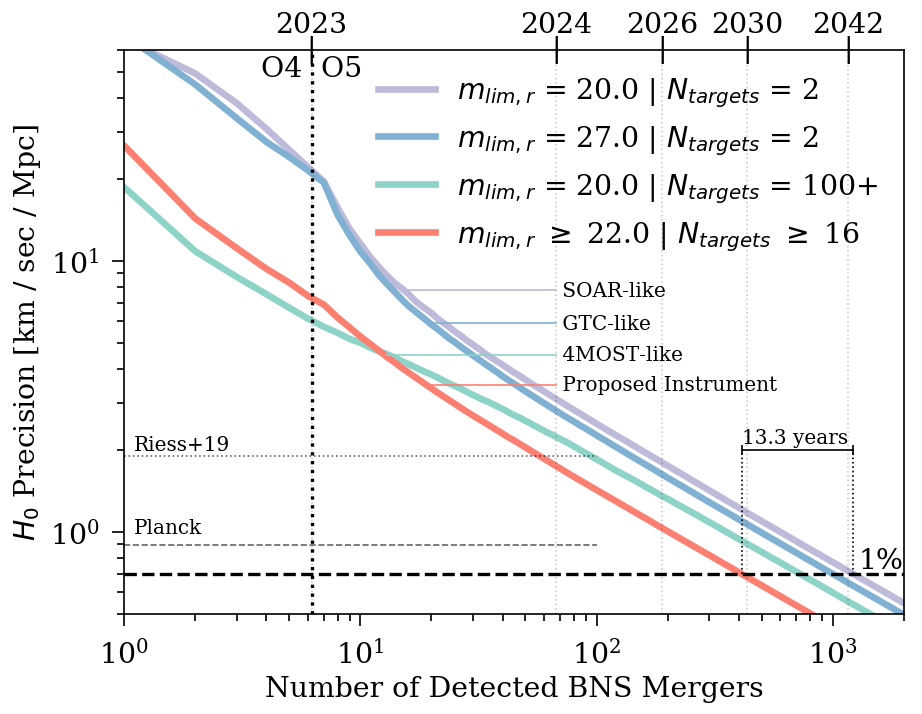

In [145]:
plt_style()
plt.figure(figsize=(8,6), dpi=120)

# Plot forcasted lines
for detector in detectors.keys():
    plt.plot(np.arange(NUM_ALERTS + 1), results[detector], **plt_styles[detector])

# Years
year_map = {2023: lvc.O4_alerts}
for year in [2024, 2026, 2030, 2042]:
    year_map[year] = lvc.O5_alerts_per_year * (year - 2023) + lvc.O4_alerts
for year, n_alerts in year_map.items():
    plt.text(n_alerts, 57, "|", horizontalalignment='center')
    plt.text(n_alerts, 70, str(year), horizontalalignment='center')
    plt.axvline(n_alerts, ls=':', alpha=0.2)
    
# H0 at 1% precision
plt.axhline(0.7, ls='--', lw=2, color='black')
plt.text(2000, 0.7, "1%", horizontalalignment='right', verticalalignment='bottom')

# 1% Time Difference
alert_min = np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['OPTIMAL'] - 0.7))]  
alert_max = np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['SOAR'] - 0.7))]  
year_diff = (alert_max - alert_min) / lvc.O5_alerts_per_year
plt.plot([alert_min, alert_max], [2.0, 2.0], marker='|', color='black')
plt.text(alert_min, 2.05, "{:.1f} years".format(year_diff), fontsize=12, verticalalignment='bottom')
plt.plot([alert_min, alert_min], [0.7, 2.0], color='black', ls=':')
plt.plot([alert_max, alert_max], [0.7, 2.0], color='black', ls=':')

# Add arrow annotations
#plt.arrow(50, 5, -20, 0, color=plt_styles["SOAR"]["color"], width=0.4, head_width=3.*0.4, head_length=2*0.4)
#plt.arrow(50, 3, -20, 0, color=plt_styles["OPTIMAL"]["color"], width=0.15, zorder=40)
plt.plot([np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['SOAR'] - 7.8))], year_map[2024]], [7.8]*2, color=plt_styles["SOAR"]["color"])
plt.plot([np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['GTC'] - 5.9))], year_map[2024]], [5.9]*2, color=plt_styles["GTC"]["color"])
plt.plot([np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['4MOST'] - 4.5))], year_map[2024]], [4.5]*2, color=plt_styles["4MOST"]["color"])
plt.plot([np.arange(NUM_ALERTS + 1)[np.argmin(np.abs(results['OPTIMAL'] - 3.5))], year_map[2024]], [3.5]*2, color=plt_styles["OPTIMAL"]["color"])
plt.text(year_map[2024], 7.8, " SOAR-like", fontsize=12, verticalalignment='center')
plt.text(year_map[2024], 5.9, " GTC-like", fontsize=12, verticalalignment='center')
plt.text(year_map[2024], 4.5, " 4MOST-like", fontsize=12, verticalalignment='center')
plt.text(year_map[2024], 3.5, " Proposed Instrument", fontsize=12, verticalalignment='center')
    
# Plot O4-O5 transition
plt.axvline(x=lvc.O4_alerts, ls=":", c="black", lw=2)
plt.text(lvc.O4_alerts, 48, "O4 ", horizontalalignment='right')
plt.text(lvc.O4_alerts, 48, " O5", horizontalalignment='left')

# Existing / Expected Constraints from other probes
sn = 1.9 #* 0.7
pl = 0.6/67.27*100 #*0.7
plt.plot([1,100],[pl,pl],'k--',alpha=0.6)
plt.plot([1,100],[sn,sn],'k:',alpha=0.6)
plt.text(1.1,pl+0.1,'Planck', fontsize=12)
plt.text(1.1,sn+0.1,'Riess+19', fontsize=12)
    
# Plot formatting
plt.legend()
plt.ylim(0.5, 60)
plt.xlim(1, NUM_ALERTS)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("$H_0$ Precision [km / sec / Mpc]")
plt.xlabel("Number of Detected BNS Mergers")


plt.tight_layout()

plt.savefig('GW_forecast_plot.pdf')

plt.show()